# Классификация веб-страниц с помощью BERT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/cmc/classif_wp

/content/drive/MyDrive/cmc/classif_wp


## Загрузка необходимых модулей

In [3]:
from platform import python_version

print(python_version())

3.9.16


In [4]:
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.8 MB/s eta 0:00:00


In [5]:
!pip3 install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.2 MB/s eta 0:00:00


In [6]:
!pip3 install pymorphy3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 57.7 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13721 sha256=dffe3f6c200fe21ada9519737763f5cdebfcf1bd44dc882e7bee624fc46f2d2f
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt


In [7]:
!pip3 install fastBPE sacremoses subword_nmt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastBPE: filename=fastBPE-0.1.0-cp39-cp39-linux_x86_64.whl size=762583 sha256=bf8829789ee48f4d8199c2b36957bf46caf4815c5029002a32d4caaa433c381a
  Stored in directory: /root/.cache/pip/wheels/e1/10/20/0691b69b472ff8530a7e608674d5bd1cbc772f4d6071c8accf
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895259 sha256=c276ea74e56b2197d718fe97d24319390db5d39e4e9ba3ad650501e568288c4d
  Stored in directory: /root/.cache/pip/wheels/12/1c/3d/46cf06718d63a32ff798a89594b61e7f345ab6b36d909ce033
Successfully built fastBPE sacremoses


In [8]:
!pip3 install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.1 MB/s eta 0:00:00


In [9]:
!pip3 install torch-optimizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.1 MB/s eta 0:00:00


In [10]:
import pandas as pd
from tqdm import tqdm
import nltk
import collections
import os
import time
import random
from keras_preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import collections
import pymorphy3
import numpy as np
import re
from sklearn.model_selection import train_test_split
import torch
import torch_optimizer as optim
from torch.utils.data import (TensorDataset,
                              DataLoader,
                              RandomSampler, SequentialSampler)

from transformers import AutoConfig, AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import AdamW
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import nltk

In [11]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [12]:
file = open("data/stop_words_russian.txt", "r")
stop_words = file.read().splitlines()

In [13]:
morph = pymorphy3.MorphAnalyzer()

In [14]:
tqdm.pandas()

In [15]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

## Загрузка датасета

In [17]:
df = pd.read_csv('datasets/foss/merge_augment_syn_swap_trnl.csv', index_col=0)
df.shape

(13864, 2)

In [18]:
df['document'].replace('', np.nan, inplace=True)
df = df.dropna().reset_index(drop=True)
df.shape

(13861, 2)

In [19]:
df.sample(3)

,document,category
11445,После пяти лет разработки представлен выпуск д...,SYSADM
7612,Postman - это очень популярная среди разработч...,DEV
4477,Открытый модификация Salesforce исследования R...,OPENING


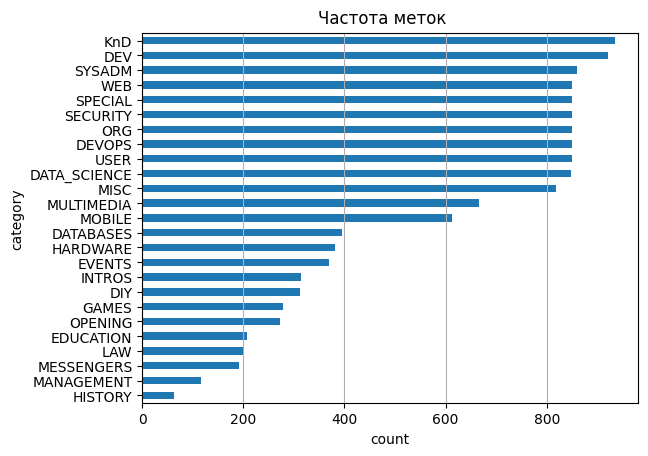

In [20]:
fig, ax = plt.subplots()
fig.suptitle("Частота меток", y=0.93)
df['category'].reset_index().groupby('category').count().sort_values(by= 
       'index').plot(kind='barh', legend=False, 
        ax=ax).grid(axis='x')
        
ax.set_xlabel('count')
ax.set_ylabel('category')
#fig.savefig('category_count.pdf', bbox_inches='tight')
fig.show()

In [21]:
# преобразование нечисловых меток в числовые метки, а также их реверс, который понадобится после обучения
category_index = {i[1]:i[0] for i in enumerate(df.category.unique())}
reverse_category_index = {i[0]:i[1] for i in enumerate(df.category.unique())}

In [22]:
category_index

{'SPECIAL': 0,
 'USER': 1,
 'SYSADM': 2,
 'WEB': 3,
 'SECURITY': 4,
 'DATA_SCIENCE': 5,
 'MULTIMEDIA': 6,
 'OPENING': 7,
 'MISC': 8,
 'MOBILE': 9,
 'ORG': 10,
 'HISTORY': 11,
 'DEVOPS': 12,
 'MANAGEMENT': 13,
 'MESSENGERS': 14,
 'DATABASES': 15,
 'LAW': 16,
 'EDUCATION': 17,
 'GAMES': 18,
 'HARDWARE': 19,
 'EVENTS': 20,
 'DIY': 21,
 'INTROS': 22,
 'KnD': 23,
 'DEV': 24}

In [23]:
labels = [category_index[i] for i in df.category.values]

In [24]:
df['document'][6], df['category'][6]

('ставить ic внутренний sd карту воспоминание микропроцессор остаться flash свободной микропроцессор памяти семейства stmh снабжены двумя банка суверенный памяти flash удобно одном банка иметься другом аппаратный код временной сведение перезаписываться внутренней делать flash аналогия eeprom сравнительно неплохой написано апноуте st уровня некоторого храниться системность встроить данные именованных файлах жёсткий удобнее структурах -файл реюзинг упрощаться поддержку облегчить преемственности перк версие файлы даунгрейды освобождают размещений хлопот координация флеш-память разруливанием конфликтов размещения блочный сервис разрабатываются модули такой обособленно системе файловой хранить различный комбинация версии характеристика устройства сертификаты различный ключи сервисам диагностические кэширование облачным аварийные временные файлы стандартные -файл энергоресурс буква глиф hmi утилит стилистика страничка web проч являться одномерный система относить файловая журналируемых класс

## Предварительная обработка данных

In [25]:
def normalize_text(text):
    # приведение к нижнему регистру 
    lower_result = text.lower()
    # удаление url-адресов
    non_links_result = re.sub(r"\S*https?:\S*", "", lower_result)
    # удаление emails
    non_emails_result = re.sub(r"\S*@\S*\s?", "", non_links_result)
    # удаление цифр
    non_numeric_result = ''.join([i for i in non_emails_result if not i.isdigit()])
    # удаление пунктуации и специальных символов
    non_punc_result = ''.join(filter(lambda mark: ord(mark) == 774 or mark.isalnum() or mark.isspace(), non_numeric_result)).strip()
    # удаление лишних пробелов
    non_space_result = re.sub(r" +", " ", non_punc_result)
    # удаление лишних абзацев
    paragraph_list = non_space_result.split('\n')
    text = '\n'.join([p for p in paragraph_list if not p.count(' ') < 10])
    # удаление стоп-слов и длинных слов
    text_tokens = word_tokenize(text)
    #without_stop_word_tokens = [word for word in text_tokens if not word in stop_words]
    #without_long_tokens = [word for word in without_stop_word_tokens if len(word) <= 18]
    without_long_tokens = [word for word in text_tokens if len(word) <= 18]
    without_short_tokens = [word for word in without_long_tokens if len(word) >= 2]
    # лемматизация слов
    #lemmatize_result = [morph.parse(word)[0].normal_form for word in without_short_tokens]
    #filtered_text = (" ").join(lemmatize_result)
    
    return (" ").join(without_short_tokens) 

In [26]:
texts = df['document'].progress_apply(normalize_text)

100%|██████████| 13861/13861 [02:09<00:00, 106.91it/s]


In [27]:
texts[6], labels[6]

('ставить ic внутренний sd карту воспоминание микропроцессор остаться flash свободной микропроцессор памяти семейства stmh снабжены двумя банка суверенный памяти flash удобно одном банка иметься другом аппаратный код временной сведение перезаписываться внутренней делать flash аналогия eeprom сравнительно неплохой написано апноуте st уровня некоторого храниться системность встроить данные именованных файлах жёсткий удобнее структурах файл реюзинг упрощаться поддержку облегчить преемственности перк версие файлы даунгрейды освобождают размещений хлопот координация флешпамять разруливанием конфликтов размещения блочный сервис разрабатываются модули такой обособленно системе файловой хранить различный комбинация версии характеристика устройства сертификаты различный ключи сервисам диагностические кэширование облачным аварийные временные файлы стандартные файл энергоресурс буква глиф hmi утилит стилистика страничка web проч являться одномерный система относить файловая журналируемых класса о

In [28]:
assert len(texts) == len(labels) == df.shape[0]

In [29]:
lengths_list = list()
for source in texts:
    lengths_list.append(len(source.split(' ')))
max_seq_length = max(lengths_list)
min_seq_length = min(lengths_list)
avg_seq_length = np.average(lengths_list)

print(" Maximum source length ", max_seq_length)
print(" Minimum source length ", min_seq_length)
print(" Average source length ", avg_seq_length)

 Maximum source length  127785
 Minimum source length  1
 Average source length  855.8374576148907


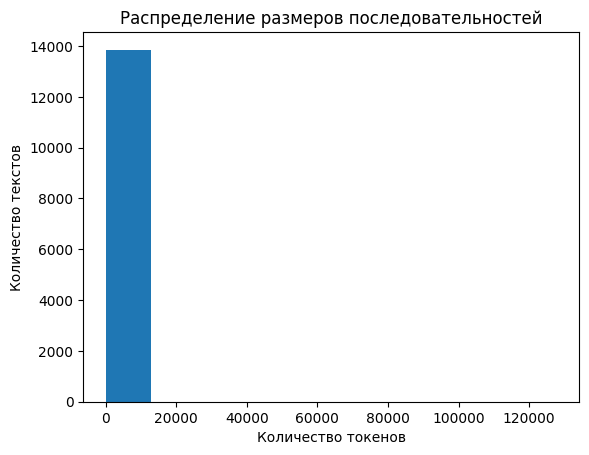

In [30]:
plt.hist(lengths_list)
plt.title('Распределение размеров последовательностей')
plt.xlabel('Количество токенов')
plt.ylabel('Количество текстов')
#plt.savefig('count_text_count_token.pdf', bbox_inches='tight')
plt.show()

## Разделение текстов на порции данных

In [31]:
def get_split(text):
  l_total = []
  l_parcial = []
  count = len(text.split())//450
  if count > 0:
    n = count
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text.split()[:500]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text.split()[w*450:w*450 + 500]
      l_total.append(" ".join(l_parcial))
  return l_total

In [32]:
extended_texts = list()
extended_labels = list()
for text, label in tqdm(zip(texts, labels), total=len(texts)):
  split_text = get_split(text)
  extended_texts.append(split_text)
  extended_labels.append([label]*len(split_text))

100%|██████████| 13861/13861 [00:12<00:00, 1146.03it/s]


In [33]:
assert len(extended_texts) == len(extended_labels) == len(labels) == len(texts)

In [34]:
extended_texts = sum(extended_texts, [])
extended_labels = sum(extended_labels, [])

In [35]:
len(extended_texts), len(extended_labels)

(25274, 25274)

In [36]:
texts = extended_texts
labels = extended_labels

In [37]:
texts1 = texts
texts = []
labels1 = []
for text, label in zip(texts1, labels):
    if len(text.split()) >= 20:
        texts.append(text)
        labels1.append(label) 

In [38]:
labels = labels1
len(texts), len(labels)

(25248, 25248)

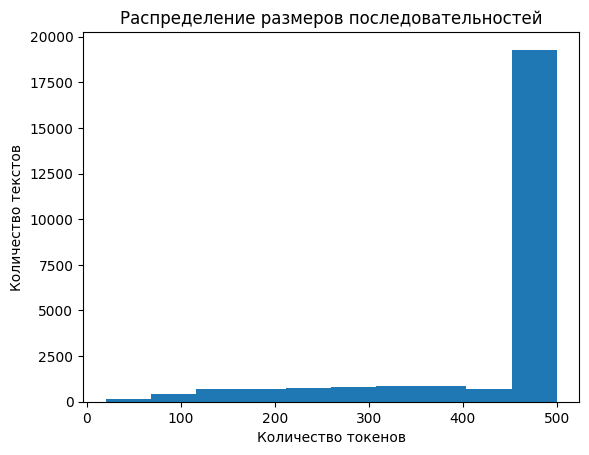

In [39]:
lengths_list = list()
for source in texts:
    lengths_list.append(len(source.split(' ')))

plt.hist(lengths_list)
plt.title('Распределение размеров последовательностей')
plt.xlabel('Количество токенов')
plt.ylabel('Количество текстов')
#plt.savefig('count_text_count_token_with_split.pdf', bbox_inches='tight')
plt.show()

In [40]:
labels_count = collections.Counter(labels)

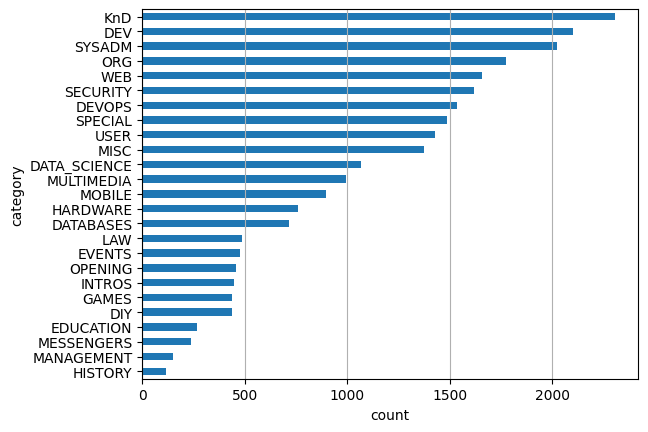

In [41]:
fig, ax = plt.subplots()
#fig.suptitle("Частота меток", y=0.93)
df_temp = pd.DataFrame({'category': list(category_index.keys()), 'count': list(labels_count.values())}, index=category_index.keys()).sort_values(by=['count'])
df_temp.plot(kind='barh', legend=False, ax=ax).grid(axis='x')
ax.set_xlabel('count')
ax.set_ylabel('category')
fig.savefig('count_category_with_split.pdf', bbox_inches='tight')
plt.show()

## Токенизация 

### Разделение данных на обучающую и тестовую выборки

In [42]:
train_texts, test_texts, train_labels, test_labels = train_test_split(list(texts), labels, random_state = 42, train_size = 0.9, stratify = labels)

len(train_texts), len(test_texts)

(22723, 2525)

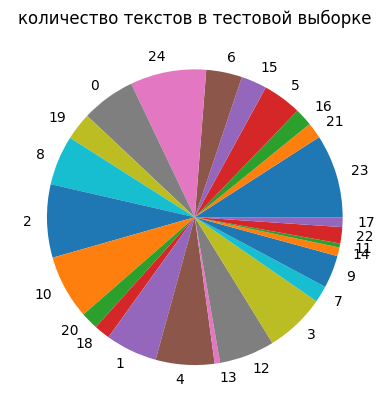

In [43]:
y = dict(collections.Counter(test_labels))
index = y.keys()
values = y.values()

plt.pie(values, labels = index)
plt.title("количество текстов в тестовой выборке")
plt.show() 

### Кодирование текстов в обучающем наборе данных

In [44]:
# токенизатор BERT
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'DeepPavlov/rubert-base-cased')

/usr/local/lib/python3.9/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip


In [45]:
# применение токенизатора к одному предложению, чтобы увидеть результат

print('Original: ', train_texts[0])
print("len(Original) = ", len(train_texts[0].split()))
print("\n")

tokenized_text = tokenizer.tokenize(train_texts[0])
print('Tokenized: ', tokenized_text)
print("len(Tokenized) = ", len(tokenized_text))
print("\n")

input_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
print('Token ids: ', input_ids)
print("len(Token ids) = ", len(input_ids))
print("\n")

Original:  значение modeshell validflags передача очередь символов неэкранированных создает проявления условия ошибки одной обработчике выполняющем удаление символов экранирования сверкой правилами sudoers обработчик некорректно разбирает присутствие неэкранированного символа обратного конце слеша строки данный считает обратный слеш экранирует символ продолжает чтение границей данных находящихся строки копируя буфер перезаписывая userargs области памяти данного границей буфера вызова выполнить переполнения манипулируя командной строке значениями sudoedit добиться наложения перезаписываемого данные хвоста влияющие дальнейший ход работы создание эксплоита упрощает полностью атакующий буфера контролирует размер userargs соответствует который размеру аргументов переданных окружения переменные контролирует размер содержимое данных записываемых границу буфера исследователям удалось эксплоита подготовить перезаписи работа содержимого строится структур sudohookentry serviceuser deftimestampdir

In [46]:
def texts_to_ids(tokenizer, texts):
    input_ids = list()
    
    for text in tqdm(texts):
        encoded_text = tokenizer.encode(text, add_special_tokens=True)
        input_ids.append(encoded_text)
    
    return input_ids

In [47]:
train_texts_ids = texts_to_ids(tokenizer, train_texts)

100%|██████████| 22723/22723 [01:04<00:00, 352.70it/s]


In [48]:
train_padding_list = pad_sequences(
    train_texts_ids,
    maxlen=500,
    dtype='long',
    truncating='post',
    padding='post'
)

In [49]:
train_attention_masks = [[float(i>0) for i in sequence] for sequence in tqdm(train_padding_list, total=len(train_padding_list))]

100%|██████████| 22723/22723 [00:05<00:00, 4256.80it/s]


In [50]:
assert len(train_texts) == len(train_labels) == len(train_attention_masks) == len(train_padding_list)

In [51]:
print('Token ids: ', train_texts_ids[0])
print("len(Token ids) = ", len(train_texts_ids[0]))
print("\n")

print('Padding: ', train_padding_list[0])
print("len(Padding) = ", len(train_padding_list[0]))
print("\n")

print('Attention masks: ', train_attention_masks[0])
print("len(Attention masks) = ", len(train_attention_masks[0]))
print("\n")

Token ids:  [101, 13971, 18929, 13776, 14013, 25972, 8599, 47018, 10925, 269, 30786, 10843, 28628, 1699, 57466, 12730, 32655, 32535, 16132, 25976, 100, 16193, 46739, 13837, 55483, 51036, 28628, 13690, 8382, 100, 42657, 10710, 10829, 11413, 16193, 8968, 100499, 23887, 61096, 29880, 1699, 57466, 16592, 43963, 59891, 7001, 2317, 40096, 33471, 100, 13012, 100, 2317, 2881, 13690, 9395, 10424, 18934, 40474, 100, 12068, 25515, 33471, 11489, 17724, 57314, 70025, 14520, 20138, 12527, 267, 16215, 4161, 15603, 17719, 100, 115348, 46695, 27441, 50245, 1757, 31273, 29552, 11440, 100, 54203, 77152, 10710, 10829, 32724, 271, 19545, 88523, 70025, 67150, 12725, 39656, 9610, 12772, 100, 11802, 7089, 14734, 5696, 3054, 7119, 97289, 9905, 100, 115348, 40436, 8835, 20138, 12527, 267, 16215, 19589, 100, 36722, 63916, 78021, 29658, 73758, 40436, 8835, 54796, 12068, 10192, 39630, 19380, 115348, 72632, 9111, 5696, 3054, 7119, 37656, 70025, 852, 13831, 73089, 36172, 16904, 10710, 10829, 11270, 92068, 26894, 281

### Разделение обучающего набора на train и validation datasets

In [52]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    train_padding_list, train_labels, 
    random_state=42,
    test_size=0.1
)

In [53]:
train_attention_masks, validation_attention_masks, _, _ = train_test_split(
    train_attention_masks,
    train_padding_list,
    random_state=42,
    test_size=0.1
)  

In [54]:
len(train_labels), len(validation_labels)

(20450, 2273)

In [55]:
assert len(train_inputs) == len(train_labels) == len(train_attention_masks)
assert len(validation_inputs) == len(validation_labels) == len(validation_attention_masks)

## Инициализация DataLoader'ов

In [56]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_attention_masks)
validation_masks = torch.tensor(validation_attention_masks)

In [57]:
# len(trainDataLoader)
# for batchIdx, sample in enumerate(trainDataloader):

In [58]:
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

## Дообучение

In [59]:
config = AutoConfig.from_pretrained('DeepPavlov/rubert-base-cased',
                                    num_labels=len(category_index),
                                    id2label=reverse_category_index,
                                    label2id=category_index)

In [60]:
model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', config=config)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

In [61]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [62]:
named_parameters = list(model.named_parameters())

In [63]:
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
grouped_parameters = [
    {'params': [p for name, p in named_parameters if not any(nd in name for nd in no_decay)],
     'weightDecay': 0.01}, # param weight
    {'params': [p for name, p in named_parameters if any(nd in name for nd in no_decay)],
     'weightDecay': 0.0} # param bias, ...
]

In [64]:
optimizer = torch.optim.AdamW(grouped_parameters, lr=2e-5)

In [65]:
def save_model(model, tokenizer, epoch):
  print(f'\nSaving on epoch {epoch+1}')
  directory = f"/content/drive/MyDrive/cmc/classif_wp/models/model_bert_2/"
  if not os.path.exists(directory):
      os.makedirs(directory)

  tokenizer.save_pretrained(directory)
  model.save_pretrained(directory)

In [66]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [67]:
def log_softmax(x):
    c = x.max()
    logsumexp = torch.log(torch.exp(x - c).sum())
    return x - c - logsumexp

class CrossEntropyLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x, labels):
        z = torch.empty(x.shape[0], x.shape[1])
        
        for i in range(x.shape[0]):
          z[i] = log_softmax(x[i])

        L = torch.empty(x.shape[0])
        for i in range(z.shape[0]):
          L[i] = z[i][labels[i]]

        return torch.mean(-torch.Tensor(L))

In [68]:
epochs = 6
best_f1_micro = 0

train_loss_values = list()
train_f1_micro_values = list()
valid_loss_values = list()
valid_f1_micro_values = list()

# переводим модель в training mode
model.train() 


total_time = time.time()

for epoch in range(epochs):
    
    start_time = time.time()
    print('')
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
    print('Training...')
    
    total_loss = 0

    train_preds, train_labels = list(), list()
    
    for step, batch in enumerate(train_dataloader):
        
        # переводим данные на видеокарту
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        # обнуляем градиенты
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]

        logits = outputs[1]

        total_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        batch_preds = np.argmax(logits, axis=1)     
        train_preds.extend(batch_preds)
        train_labels.extend(label_ids)
        
        loss.backward()
        
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        
        if (step) % 20 == 0 and not step == 0:
            print ('  Step {:>3,} of {}. Loss: {:.4f}'.format(step, len(train_dataloader), loss.item()))
    
    avg_train_loss = total_loss / len(train_dataloader) 
    train_f1_micro = f1_score(train_labels, train_preds, average="micro")

    train_loss_values.append(avg_train_loss)
    train_f1_micro_values.append(train_f1_micro)
    
    print('')
    print('  Training f1-micro: {0:.2%}'.format(train_f1_micro))
    print('  Training loss: {0:.4f}'.format(avg_train_loss))
    
    epoch_mins, epoch_secs = epoch_time(start_time, time.time())
    
    print(f'  Training epoch took: {epoch_mins}m {epoch_secs}s')
    
    print('')
    print('Running Validation...')
    
    validation_time = time.time()
    
    # переводим модель в evaluation mode
    model.eval()
    
    total_eval_loss = 0
    
    valid_preds, valid_labels = list(), list()
    
    for batch in validation_dataloader:
        
        # добавляем батч для вычисления на GPU
        batch = tuple(t.to(device) for t in batch)
        
        b_input_ids, b_input_mask, b_labels = batch

     
        with torch.no_grad():        

            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask, 
                            labels=b_labels)

        logits = outputs[1] 

        loss = outputs[0] 

        total_eval_loss += loss.item()
        
        # перемещаем логиты и метки на CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        batch_preds = np.argmax(logits, axis=1)   
        valid_preds.extend(batch_preds)
        valid_labels.extend(label_ids)

    epoch_mins, epoch_secs = epoch_time(validation_time, time.time())

    avg_val_loss = total_eval_loss / len(validation_dataloader) 
    valid_f1_micro = f1_score(valid_labels, valid_preds, average="micro")
    valid_loss_values.append(avg_val_loss)
    valid_f1_micro_values.append(valid_f1_micro)

    print('  F1-micro: {0:.2%}'.format(valid_f1_micro))
    print('   Validation loss: {0:.4f}'.format(avg_val_loss))
    print(f'  Validation took: {epoch_mins}m {epoch_secs}s')
    
    if valid_f1_micro > best_f1_micro:
      best_f1_micro = valid_f1_micro
      save_model(model, tokenizer, epoch)
        
epoch_mins, epoch_secs = epoch_time(total_time, time.time()) 
 
print('\n')
print('Training complete!')
print(f'Total training took: {epoch_mins}m {epoch_secs}s')   


======== Epoch 1 / 6 ========
Training...
  Step  20 of 1279. Loss: 2.9917
  Step  40 of 1279. Loss: 2.9311
  Step  60 of 1279. Loss: 2.9992
  Step  80 of 1279. Loss: 2.9746
  Step 100 of 1279. Loss: 2.8545
  Step 120 of 1279. Loss: 2.6713
  Step 140 of 1279. Loss: 2.7075
  Step 160 of 1279. Loss: 2.4271
  Step 180 of 1279. Loss: 2.5605
  Step 200 of 1279. Loss: 2.5559
  Step 220 of 1279. Loss: 2.0136
  Step 240 of 1279. Loss: 2.7493
  Step 260 of 1279. Loss: 1.8295
  Step 280 of 1279. Loss: 2.1314
  Step 300 of 1279. Loss: 2.3535
  Step 320 of 1279. Loss: 1.9974
  Step 340 of 1279. Loss: 2.0304
  Step 360 of 1279. Loss: 1.8757
  Step 380 of 1279. Loss: 2.2914
  Step 400 of 1279. Loss: 1.8040
  Step 420 of 1279. Loss: 2.2430
  Step 440 of 1279. Loss: 1.7876
  Step 460 of 1279. Loss: 1.7876
  Step 480 of 1279. Loss: 1.6165
  Step 500 of 1279. Loss: 1.6581
  Step 520 of 1279. Loss: 1.4897
  Step 540 of 1279. Loss: 1.0770
  Step 560 of 1279. Loss: 1.2262
  Step 580 of 1279. Loss: 1.7894


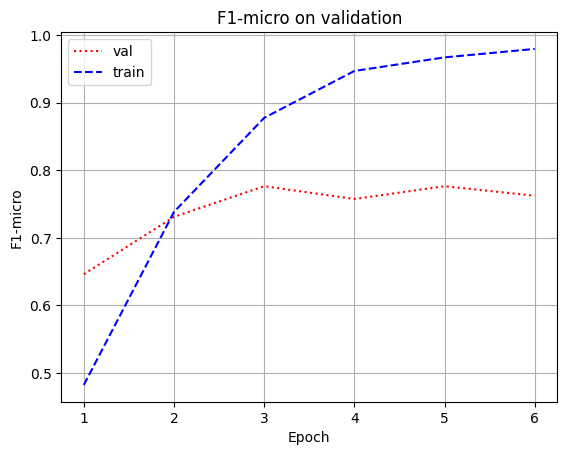

In [69]:
epochs = range(1, 7)
train =  train_f1_micro_values
valid = valid_f1_micro_values

fig, axs = plt.subplots()

axs.plot(epochs, valid, linestyle = 'dotted', label='val', color='red')
axs.plot(epochs, train, '--', label='train', color='blue')
axs.grid()
plt.title('F1-micro on validation')
#plt.title('F1-micro on train and validation')
plt.xlabel('Epoch')
plt.ylabel('F1-micro')
axs.legend(loc='best')
plt.xticks(epochs)
#plt.savefig('result_sep_txt.pdf')
plt.show()

## Тестирование модели 

In [ ]:
# config
config = AutoConfig.from_pretrained('/content/drive/MyDrive/cmc/classif_wp/models/model_bert_2/')
# tokenizer
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/cmc/classif_wp/models/model_bert_2/', pad_to_max_length=True)
# model
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/cmc/classif_wp/models/model_bert_2/', config=config)

In [70]:
test_texts_ids = texts_to_ids(tokenizer, test_texts)

100%|██████████| 2525/2525 [00:07<00:00, 348.93it/s]


In [71]:
test_padding_list = pad_sequences(
    test_texts_ids,
    maxlen=500,
    dtype='long',
    truncating='post',
    padding='post'
)

In [72]:
test_attention_masks = [[float(i>0) for i in sequence] for sequence in tqdm(test_padding_list, total=len(test_padding_list))]

100%|██████████| 2525/2525 [00:00<00:00, 4354.18it/s]


In [73]:
assert len(test_texts) == len(test_labels) == len(test_attention_masks) == len(test_padding_list)

In [74]:
test_inputs = torch.tensor(test_padding_list)

test_labels = torch.tensor(test_labels)

test_masks = torch.tensor(test_attention_masks)

In [75]:
batch_size = 16

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [76]:
print('Predicting labels for {:,} test texts'.format(len(test_inputs)))

model.eval()

predictions, true_labels = [], []

total_time = time.time()

for batch in test_dataloader:
    
    batch = tuple(t.to(device) for t in batch)
  
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():

        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_preds = np.argmax(logits, axis=1)

    predictions.extend(batch_preds) 
    true_labels.extend(label_ids)

epoch_mins, epoch_secs = epoch_time(total_time, time.time()) 
 
print(f'Total testing took: {epoch_mins}m {epoch_secs}s') 

Predicting labels for 2,525 test texts
Total testing took: 1m 20s


In [77]:
print("F1-micro           ", f1_score(true_labels, predictions, average="micro"))
print(classification_report(true_labels, predictions, target_names=reverse_category_index.values(), zero_division=True))

F1-micro            0.7596039603960397
              precision    recall  f1-score   support

     SPECIAL       0.73      0.77      0.75       149
        USER       0.81      0.64      0.71       143
      SYSADM       0.68      0.87      0.76       202
         WEB       0.84      0.80      0.82       166
    SECURITY       0.75      0.77      0.76       162
DATA_SCIENCE       0.95      0.84      0.89       107
  MULTIMEDIA       0.95      0.82      0.88        99
     OPENING       0.73      0.65      0.69        46
        MISC       0.51      0.84      0.64       137
      MOBILE       0.93      0.78      0.85        90
         ORG       0.56      0.81      0.67       177
     HISTORY       0.80      0.73      0.76        11
      DEVOPS       0.86      0.78      0.82       153
  MANAGEMENT       1.00      0.40      0.57        15
  MESSENGERS       0.87      0.83      0.85        24
   DATABASES       0.86      0.87      0.87        71
         LAW       0.82      0.82      0.8

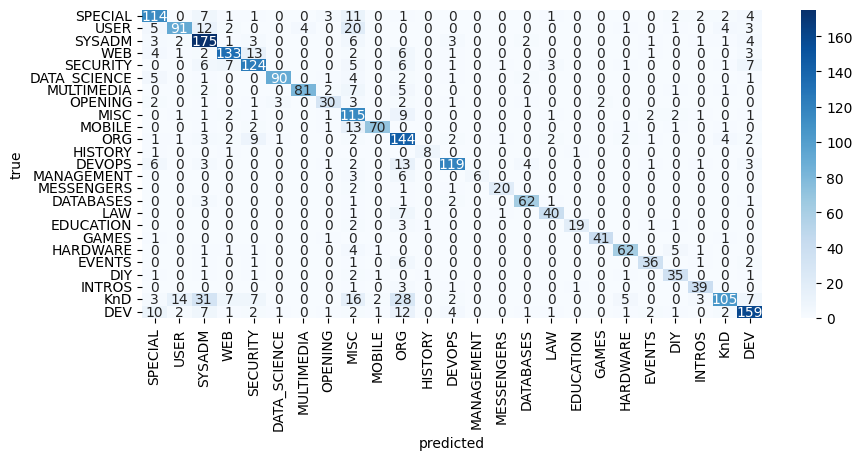

In [97]:
import seaborn as sns

x_axis_labels = reverse_category_index.values()

y_axis_labels = reverse_category_index.values()

cm = confusion_matrix(true_labels, predictions)
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(cm, annot=True, xticklabels=x_axis_labels, square=False, yticklabels=y_axis_labels, fmt='d', ax=ax, cmap=plt.cm.Blues)
ax.set(xlabel="predicted", ylabel="true")
plt.yticks(rotation=0)
plt.savefig('confmatrix.pdf', bbox_inches = "tight")
plt.show()

## Загрузка дообученной модели и предсказание новых веб-страниц

In [139]:
# config
config = AutoConfig.from_pretrained('/content/drive/MyDrive/cmc/classif_wp/models/model_bert_2/')
# tokenizer
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/cmc/classif_wp/models/model_bert_2/', pad_to_max_length=True)
# model
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/cmc/classif_wp/models/model_bert_2/', config=config)

In [140]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [141]:
predict_df = pd.read_csv('data/predict_new_web_pages.csv')

In [142]:
texts = predict_df['document'].progress_apply(normalize_text)

100%|██████████| 24/24 [00:00<00:00, 102.80it/s]


In [143]:
labels = list(predict_df['category'])

In [144]:
extended_texts = list()
extended_labels = list()
indexes = list()

for index, (text, label) in enumerate(zip(texts, labels)):
  split_text = get_split(text)
  extended_texts.append(split_text)
  extended_labels.append([label]*len(split_text))
  indexes.append([index]*len(split_text))

extended_texts = sum(extended_texts, [])
extended_labels = sum(extended_labels, [])
indexes = sum(indexes, [])

texts = []
labels = []
indexes1 = []
for index, (text, label) in enumerate(zip(extended_texts, extended_labels)):
    if len(text.split()) >= 20:
        texts.append(text)
        labels.append(label)
        indexes1.append(indexes[index]) 

In [145]:
len(texts), len(labels), len(indexes1)

(51, 51, 51)

In [105]:
web_pages = ['https://habr.com/ru/post/538156', 'https://habr.com/ru/post/536732', 
'https://habr.com/ru/news/t/587616', 'https://habr.com/ru/post/587216', 'https://habr.com/ru/post/588526', 
'https://habr.com/ru/news/t/584446', 'https://habr.com/ru/post/583014', 
'https://habr.com/ru/news/t/583704', 'https://habr.com/ru/news/t/584698', 
'https://habr.com/ru/news/t/573186', 'https://habr.com/ru/news/t/573464', 
'https://habr.com/ru/post/569256', 'https://habr.com/ru/post/570330',
'https://habr.com/ru/post/574548','https://habr.com/ru/news/t/575530', 
'https://habr.com/ru/news/t/578002', 'https://habr.com/ru/post/577662', 'https://habr.com/ru/post/580040', 
'https://habr.com/ru/post/592797', 'https://habr.com/ru/post/526470', 
'https://habr.com/ru/post/521190', 'https://habr.com/ru/post/530774', 
'https://habr.com/ru/post/530992', 'https://habr.com/ru/post/532460']
#df_new.loc[len(df_new)] = ['https://habr.com/ru/news/t/583482', 'EVENTS']

In [146]:
result_df = pd.DataFrame(columns=['текст', 'предсказанная категория', 'истинная категория'])

In [147]:
model.to('cpu')
model.eval()

for index, (text, label) in enumerate(zip(texts, labels)): 
  input_ids_new = list()
  attention_masks_new = list()
  encoded_dict = tokenizer.encode_plus(
                      text,                            
                      add_special_tokens=True,       
                      max_length=500,                
                      padding='max_length',         
                      truncation=True,               
                      return_attention_mask=True,   
                      return_tensors='pt',          
                  )
        
  input_ids_new.append(encoded_dict['input_ids'])

  attention_masks_new.append(encoded_dict['attention_mask'])
      
  input_ids_new = torch.cat(input_ids_new, dim=0)
  attention_masks_new = torch.cat(attention_masks_new, dim=0)

  with torch.no_grad():
    outputs = model(input_ids_new, token_type_ids=None, attention_mask=attention_masks_new)
    
  logits = outputs[0].detach().numpy()

  pred_category = np.argmax(logits, axis=1)

  pred = reverse_category_index[pred_category[0]]

  result_df.loc[len(result_df.index)] = [text, pred, label]

In [148]:
result_df['индекс веб-страницы'] = indexes1

In [106]:
result_df['веб_страницы'] = web_pages

In [110]:
result_df = result_df.drop(columns='текст')

In [113]:
result_df = result_df[['web_pages', 'предсказанная категория', 'истинная категория']]


In [149]:
# наилучшая модель, f1-micro = 77.5% 
result_df

,текст,предсказанная категория,истинная категория,индекс веб-страницы
0,блог компании конференции олега бунина онтико ...,DEVOPS,DEVOPS,0
1,должна проверять возможно платеж таким номером...,SYSADM,DEVOPS,0
2,за счет транзакционной работы которая при инт...,DATABASES,DEVOPS,0
3,интеграцию из других систем различайте ситуац...,DIY,DEVOPS,0
4,связидублирование потери могут возникать не то...,SYSADM,DEVOPS,0
5,блог компании visiology высокая производительн...,DATABASES,DEVOPS,1
6,данных на горячие холодные объединяет плюсы об...,DATABASES,DEVOPS,1
7,резервное копирование хранение данных статисти...,DATABASES,OPENING,2
8,блог компании firstvds системное администриров...,DEVOPS,SYSADM,3
9,них это те данные которые доступны по сети вот...,SECURITY,SYSADM,3


## Графики экспериментов 

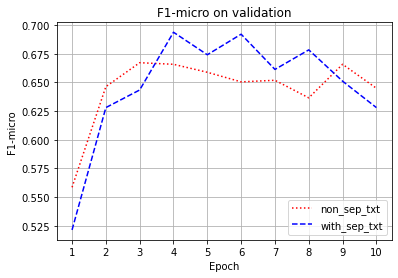

In [ ]:
epochs = range(1, 11)
non_sep_txt = [0.5584958217270195, 0.6462395543175488, 0.6671309192200557, 0.6657381615598886, 0.658774373259053, 
               0.6504178272980501, 0.6518105849582173, 0.6364902506963789, 0.6657381615598886, 0.644846796657381]
with_sep_txt = [0.5213310580204779, 0.6279863481228669, 0.643344709897611, 0.6936860068259386, 0.674061433447099,
                0.6919795221843004, 0.6612627986348123, 0.6783276450511946, 0.6510238907849829, 0.6279863481228669]

fig, axs = plt.subplots()

axs.plot(epochs, non_sep_txt, linestyle = 'dotted', label='non_sep_txt', color='red')
#axs.plot(epochs, [0.66, 0.66, 0.55, 0.55, 0.60, 0.60, 0.76, 0.76, 0.78, 0.73], '-.', label='train', color='green')
axs.plot(epochs, with_sep_txt, '--', label='with_sep_txt', color='blue')
axs.grid()
plt.title('F1-micro on validation')
#plt.title('F1-micro on train and validation')
plt.xlabel('Epoch')
plt.ylabel('F1-micro')
axs.legend(loc='best')
plt.xticks(epochs)
plt.savefig('result_sep_txt.pdf')
plt.show()

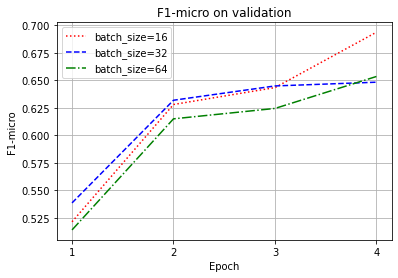

In [77]:
import matplotlib.pyplot as plt
epochs = range(1, 5)
batch_16 = [0.5213310580204779, 0.6279863481228669, 0.643344709897611, 0.6936860068259386]
batch_32 = [0.5384958217270195, 0.6318491283947473, 0.6448523495728412, 0.6482548925748575]
batch_64 = [0.5139282948273584, 0.6149432584258442, 0.6243948854753753, 0.6534498578345742]

fig, axs = plt.subplots()

axs.plot(epochs, batch_16, linestyle = 'dotted', label='batch_size=16', color='red')
axs.plot(epochs, batch_32, '--', label='batch_size=32', color='blue')
axs.plot(epochs, batch_64, '-.', label='batch_size=64', color='green')
axs.grid()
plt.title('F1-micro on validation')
#plt.title('F1-micro on train and validation')
plt.xlabel('Epoch')
plt.ylabel('F1-micro')
axs.legend(loc='best')
plt.xticks(epochs)
plt.savefig('result_batch.pdf')
plt.show()

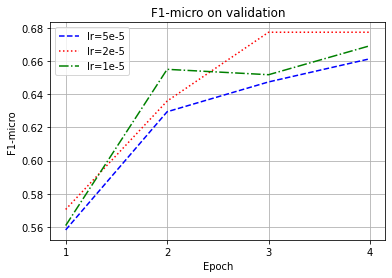

In [76]:
import matplotlib.pyplot as plt
epochs = range(1, 5)
lr_2 = [0.5705467372134039, 0.6358024691358025, 0.6772486772486772, 0.6772486772486772]
lr_1 = [0.5608465608465608, 0.6549206349206349, 0.6516754850088183, 0.6691393298059964]
lr_5 = [0.5582190377123261, 0.6293716976127632, 0.6473297414396226, 0.6612910382021128]

fig, axs = plt.subplots()

axs.plot(epochs, lr_5, '--', label='lr=5e-5', color='blue')
axs.plot(epochs, lr_2, linestyle = 'dotted', label='lr=2e-5', color='red')
axs.plot(epochs, lr_1, '-.', label='lr=1e-5', color='green')
axs.grid()
plt.title('F1-micro on validation')
#plt.title('F1-micro on train and validation')
plt.xlabel('Epoch')
plt.ylabel('F1-micro')
axs.legend(loc='best')
plt.xticks(epochs)
plt.savefig('result_lr.pdf')
plt.show()

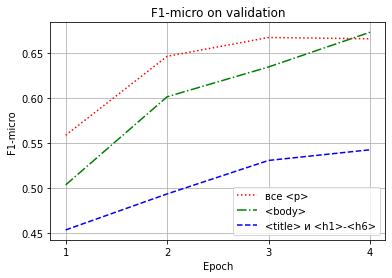

In [ ]:
epochs = range(1, 5)
all_p = [0.5584958217270195, 0.6462395543175488, 0.6671309192200557, 0.6657381615598886]
body = [0.50324521938154321, 0.6012348129324834, 0.6343934985943304, 0.6729843934834939]
title_h1_h6 = [0.45320984338438939, 0.49324939423294, 0.530459492349, 0.542309494031930]

fig, axs = plt.subplots()

axs.plot(epochs, all_p, linestyle = 'dotted', label='все <p>', color='red')
axs.plot(epochs, body, '-.', label='<body>', color='green')
axs.plot(epochs, title_h1_h6, '--', label='<title> и <h1>-<h6>', color='blue')
axs.grid()
plt.title('F1-micro on validation')
plt.xlabel('Epoch')
plt.ylabel('F1-micro')
axs.legend(loc='best')
plt.xticks(epochs)
#plt.savefig('test_tags.pdf')
plt.show()

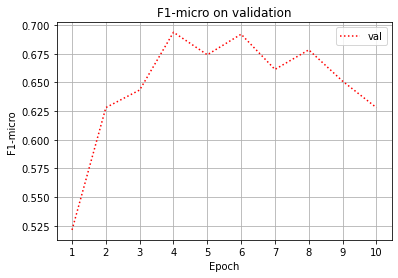

In [ ]:
epochs = range(1, 11)
train = [0.41208270106221545, 0.6443474962063733, 0.7773141122913505, 0.8728186646433991, 0.9286798179059181, 
         0.957701062215478, 0.9724962063732928, 0.9764795144157815, 0.9801783004552352, 0.9820751138088012]
valid = [0.5213310580204779, 0.6279863481228669, 0.643344709897611, 0.6936860068259386, 0.674061433447099,
 0.6919795221843004, 0.6612627986348123, 0.6783276450511946, 0.6510238907849829, 0.6279863481228669]

fig, axs = plt.subplots()

axs.plot(epochs, valid, linestyle = 'dotted', label='val', color='red')
axs.grid()
plt.title('F1-micro on validation')
plt.xlabel('Epoch')
plt.ylabel('F1-micro')
axs.legend(loc='best')
plt.xticks(epochs)
#plt.savefig('test_val.pdf')
plt.show()

In [ ]:
# dataset lenta.ru

epochs = range(1, 11)
train = [0.7813603662524525, 0.9234139960758666, 0.9684761281883584, 0.9836494440810988, 0.9892086330935251,
      0.9891432308698496, 0.991563113145847, 0.9935251798561151, 0.9939829954218443, 0.9945716154349248]
valid = [[0.8793407886992348, 0.9005297233666862, 0.8952324896998234, 0.9046497939964685, 0.8993525603296056,
      0.9040612124779281, 0.8975868157739847, 0.9028840494408475, 0.8940553266627428, 0.9158328428487346]]

fig, axs = plt.subplots()

axs.plot(epochs, val, linestyle = 'dotted', label='val', color='red')
axs.plot(epochs, train, '--', label='train', color='blue')
axs.grid()
plt.title('F1-micro on validation (lenta.ru)')
#plt.title('F1-micro on train and validation')
plt.xlabel('Epoch')
plt.ylabel('F1-micro')
axs.legend(loc='best')
plt.xticks(epochs)
#plt.savefig('result_sep_txt.pdf')
plt.show()

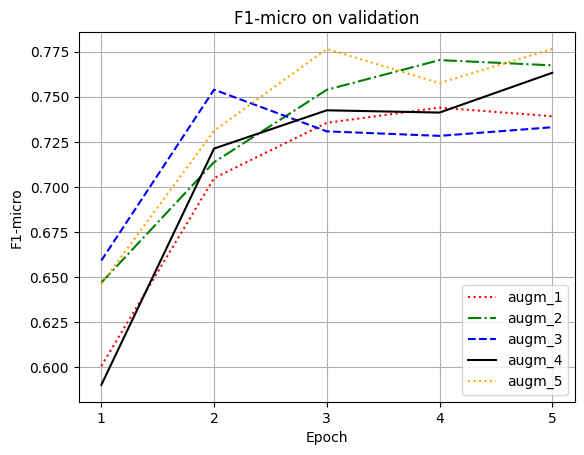

In [167]:
import matplotlib.pyplot as plt
epochs = range(1, 6)
augm3 = [0.6592388182328311, 0.7539294324882132, 0.7308341493498717, 0.7283291382482833, 0.7331094882307212]
augm1 = [0.6007966885281153, 0.7049166756262768, 0.7355510160197828, 0.7439845177937856, 0.7391963229760241]
augm2 = [0.6470019342359767, 0.7137330754352033, 0.7538684719535783, 0.7703094777562862, 0.7674081237911026]
augm4 = [0.5903284134783439, 0.7212938123782327, 0.7424987481364363, 0.7412398413971811, 0.7632643717345211]
augm5 = [0.6462824461064672, 0.7311922569291684, 0.7765068191816982, 0.7575890893092829, 0.7765068191816982]

fig, axs = plt.subplots()

axs.plot(epochs, augm1, linestyle = 'dotted', label='augm_1', color='red')
axs.plot(epochs, augm2, '-.', label='augm_2', color='green')
axs.plot(epochs, augm3, '--', label='augm_3', color='blue')
axs.plot(epochs, augm4, label='augm_4', color='black')
axs.plot(epochs, augm5, ':', label='augm_5', color='orange')
axs.grid()
plt.title('F1-micro on validation')
#plt.title('F1-micro on validation')
plt.xlabel('Epoch')
plt.ylabel('F1-micro')
axs.legend(loc='best')
plt.xticks(epochs)
plt.savefig('augms_valid.pdf')
plt.show()